In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import polars as pl

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics
from src.IDs import *


# Choose sample and chrom

In [4]:
focal_sample_id = "1894"
t2t_chrom = "chr2"
denovo_chrom = t2t_chrom + "_RagTag"



# Mix high-conf SNPs and two-sided single nuc mismatches

## Get mismatches

In [5]:
def do_it_all(focal_sample_id, denovo_chrom):
    filtered_high_conf_mismatches_df = pl.scan_parquet(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.high_confidence_snps.parquet")
    
    
    filtered_high_conf_mismatches_df = diagnostics.add_high_confidence_annotation(
        filtered_high_conf_mismatches_df,
        base_qual_min = 0, # Don't filter on this just yet
    )
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.filter("is_high_conf_event")
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.collect(streaming=True)
    
    #
    # 3. Find mismatches supported by flanking high conf SNPs (putative GC)
    #
    def F(df):
        df = (df
            .with_columns(
                pl.col("fits1").cum_sum().alias("fits1_before"),
                pl.col("fits1").cum_sum(reverse=True).alias("fits1_after"),
                pl.col("fits2").cum_sum().alias("fits2_before"),
                pl.col("fits2").cum_sum(reverse=True).alias("fits2_after"),
            )
        )
        return df

    context_df = (filtered_high_conf_mismatches_df
        .with_columns(
            (pl.col("op1") == 7).alias("fits1").cast(int),
            (pl.col("op2") == 7).alias("fits2").cast(int),
        )
        .sort("start")
        .group_by("read_name")    
        .map_groups(F)
    )
    
    #
    # 4. Calculate stats
    # 
    flanking = 3

    # Filter for putative GC events
    putative_gc_df_hap = pl.concat(
        [
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("fits1_before") >= flanking) & (pl.col("fits1_after") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("fits2_before") >= flanking) & (pl.col("fits2_after") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
            ),
        ]
    )
    
    # Mark where there are two different SNPs
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns((pl.col("refseq_start1") != pl.col("refseq_start2")).alias("diff_in_haplotypes"))
    )
    
    # Make the three categories
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns(
            pl.when(pl.col('diff_in_haplotypes') & pl.col("other_op_equal")).then(pl.lit("x_vs_y/x"))
              .when(pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/z"))
              .when(~pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/y"))
              .otherwise(pl.lit("x_vs_x/x"))
              .alias('category')
        )
    )
    
    to_round = 1
    putative_gc_df_hap_cnt = (putative_gc_df_hap
        .with_columns(
            (pl.col("qual_start1") // to_round * to_round).alias("qual_rounded"),
        )
        .group_by(["qual_rounded", "category"])
        .count()
        .pivot(
            values=["count"],
            index=["qual_rounded"],
            columns=["category"],
            aggregate_function="sum",
        )
        .fill_null(0)
        .sort("qual_rounded")
        .with_columns(
            pl.lit(focal_sample_id).alias("focal_sample_id"),
            pl.lit(denovo_chrom).alias("chrom"),
        )
    )
    
    return putative_gc_df_hap_cnt
    
    

# Get them all

In [6]:
%%time 
# dfs = []
# for chrom in aut_chrom_names[1:2]:
#     print(chrom)
#     dfs.append(do_it_all(focal_sample_id, chrom + "_RagTag"))
dfs = joblib.Parallel(n_jobs=8, verbose=50)(
    joblib.delayed(do_it_all)(focal_sample_id, chrom + "_RagTag") \
    for chrom in aut_chrom_names
    for focal_sample_id in sudmant_sample_ids
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  9.2min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed: 11.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed: 11.6min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed: 11.7min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed: 12.0min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed: 12.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed: 12.5min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed: 13.1min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed: 21.1min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed: 21.9min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed: 22.1min


/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed: 22.2min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed: 22.8min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed: 23.2min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed: 23.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed: 23.8min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  17 tasks      | elapsed: 29.9min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  18 tasks      | elapsed: 30.6min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  19 tasks      | elapsed: 31.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  20 tasks      | elapsed: 31.8min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  21 tasks      | elapsed: 32.0min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  22 tasks      | elapsed: 32.6min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  23 tasks      | elapsed: 33.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  24 tasks      | elapsed: 34.1min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 38.6min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  26 tasks      | elapsed: 39.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  27 tasks      | elapsed: 39.9min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  28 tasks      | elapsed: 40.7min
[Parallel(n_jobs=8)]: Done  29 tasks      | elapsed: 40.7min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  30 tasks      | elapsed: 41.6min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  31 tasks      | elapsed: 41.7min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  32 tasks      | elapsed: 42.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  33 tasks      | elapsed: 47.7min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 48.0min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  35 tasks      | elapsed: 48.1min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  36 tasks      | elapsed: 48.2min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  37 tasks      | elapsed: 48.5min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  38 tasks      | elapsed: 48.8min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  39 tasks      | elapsed: 49.8min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  40 tasks      | elapsed: 50.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  41 tasks      | elapsed: 54.1min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  42 tasks      | elapsed: 54.9min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  43 tasks      | elapsed: 55.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  44 tasks      | elapsed: 55.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 55.9min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  46 tasks      | elapsed: 55.9min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  47 tasks      | elapsed: 56.5min
[Parallel(n_jobs=8)]: Done  48 tasks      | elapsed: 56.5min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  49 tasks      | elapsed: 60.0min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  50 tasks      | elapsed: 60.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  51 tasks      | elapsed: 60.7min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed: 61.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  53 tasks      | elapsed: 61.7min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  54 tasks      | elapsed: 61.8min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  55 tasks      | elapsed: 62.7min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 63.2min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  57 tasks      | elapsed: 66.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  58 tasks      | elapsed: 66.7min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  59 tasks      | elapsed: 66.9min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  60 tasks      | elapsed: 67.1min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  61 tasks      | elapsed: 67.9min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  62 tasks      | elapsed: 68.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  63 tasks      | elapsed: 69.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed: 69.5min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  65 tasks      | elapsed: 71.7min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  66 tasks      | elapsed: 72.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  67 tasks      | elapsed: 73.2min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  68 tasks      | elapsed: 73.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 74.6min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  70 tasks      | elapsed: 74.7min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  71 tasks      | elapsed: 75.0min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  72 tasks      | elapsed: 75.2min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  73 tasks      | elapsed: 76.5min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  74 tasks      | elapsed: 77.1min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  75 tasks      | elapsed: 78.5min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  76 tasks      | elapsed: 78.7min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  77 tasks      | elapsed: 79.1min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  78 tasks      | elapsed: 79.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  79 tasks      | elapsed: 79.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  80 tasks      | elapsed: 79.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  81 tasks      | elapsed: 81.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 81.6min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  83 tasks      | elapsed: 82.1min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  84 tasks      | elapsed: 82.9min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  85 tasks      | elapsed: 83.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  86 tasks      | elapsed: 83.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  87 tasks      | elapsed: 83.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  88 tasks      | elapsed: 83.8min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  89 tasks      | elapsed: 84.7min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  90 tasks      | elapsed: 85.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  91 tasks      | elapsed: 86.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  92 tasks      | elapsed: 86.6min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  93 tasks      | elapsed: 86.6min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  94 tasks      | elapsed: 87.1min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  95 tasks      | elapsed: 87.1min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  96 tasks      | elapsed: 87.6min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 88.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  98 tasks      | elapsed: 88.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done  99 tasks      | elapsed: 89.6min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 100 tasks      | elapsed: 89.9min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 101 tasks      | elapsed: 89.9min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 102 tasks      | elapsed: 90.0min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 103 tasks      | elapsed: 91.1min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 104 tasks      | elapsed: 91.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 105 tasks      | elapsed: 92.0min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 106 tasks      | elapsed: 92.2min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 107 tasks      | elapsed: 92.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 108 tasks      | elapsed: 92.8min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 109 tasks      | elapsed: 92.9min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 110 tasks      | elapsed: 93.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 111 tasks      | elapsed: 93.4min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 93.5min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 113 tasks      | elapsed: 93.5min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 114 tasks      | elapsed: 94.0min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 115 tasks      | elapsed: 95.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 116 tasks      | elapsed: 95.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 117 tasks      | elapsed: 95.5min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 120 out of 132 | elapsed: 96.0min remaining:  9.6min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 123 out of 132 | elapsed: 97.0min remaining:  7.1min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 126 out of 132 | elapsed: 97.1min remaining:  4.6min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 129 out of 132 | elapsed: 97.5min remaining:  2.3min


/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
/tmp/ipykernel_2981514/4224850719.py:80: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.


[Parallel(n_jobs=8)]: Done 132 out of 132 | elapsed: 97.8min finished
CPU times: user 6.02 s, sys: 2.36 s, total: 8.38 s
Wall time: 1h 37min 48s


# Plotting 

In [7]:
def plot_per_condition(dfs, ax, condition=None):
    if condition is None:
        condition = pl.lit(True)
        
    putative_gc_df_hap_cnt = (
        pl.concat([x.filter(condition)[["qual_rounded", "x_vs_y/y", "x_vs_y/z", "x_vs_y/x"]] for x in dfs])
        .group_by(["qual_rounded"])
        .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/z").sum(), pl.col("x_vs_y/x").sum())
        .sort("qual_rounded")
    )
    
    import statsmodels.stats.proportion
    A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"][::-1])[::-1]
    B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"][::-1])[::-1]
    p = A / B 
    lo, hi = statsmodels.stats.proportion.proportion_confint(
        A, B,
        method="beta", 
        alpha=0.05
    )

    ax.errorbar(
        x = putative_gc_df_hap_cnt["qual_rounded"],
        y = p,
        yerr = [p-lo, hi-p],
        fmt = '.'
    )

    ax.axhline(0.01, ls="--", lw=0.5, c="black")
    ax.axhline(0.1, ls="--", lw=0.5, c="black")

    ax.set_xlabel("BQ (lower threshold)");
    ax.set_ylabel("Estimated false positive rate");
    ax.set_yscale("log")
    #plt.ylim(0.95,1);


    
    

## All

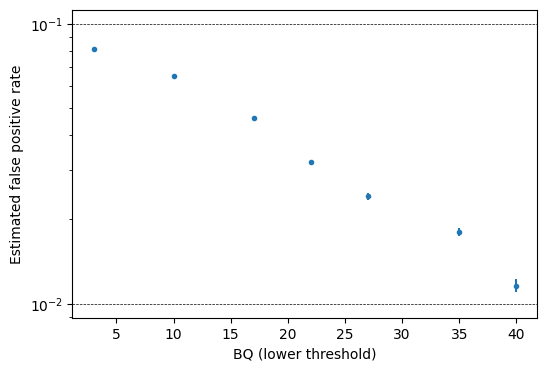

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

plot_per_condition(dfs, ax, condition=None)

## Per sample

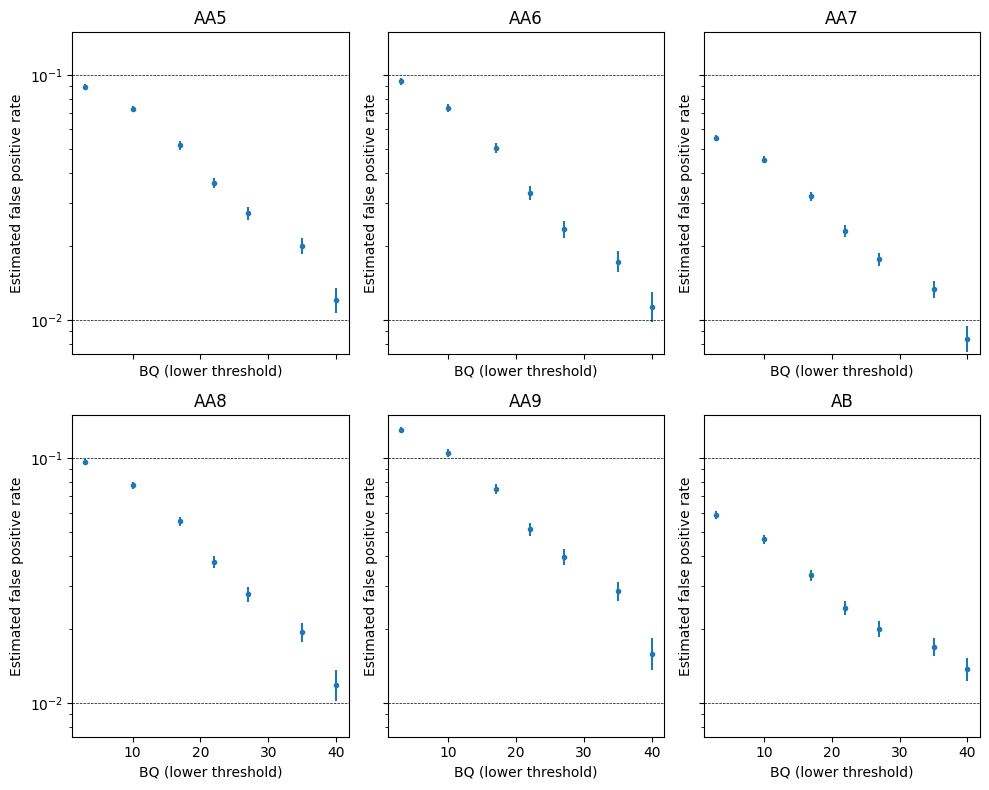

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()[:len(sudmant_sample_ids)]):
    plot_per_condition(dfs, ax, condition=(pl.col("focal_sample_id") == sudmant_sample_ids[i]))
    ax.set_title(sample_id_to_paper_label[sudmant_sample_ids[i]])

plt.tight_layout()

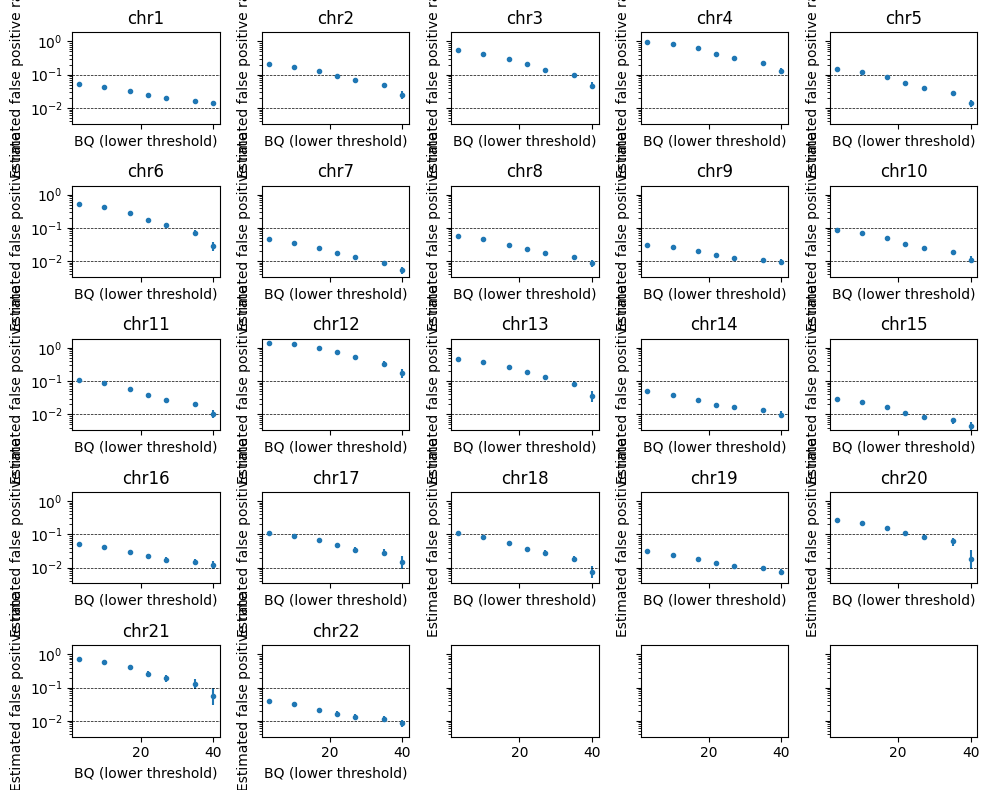

In [10]:
fig, axs = plt.subplots(5, 5, figsize=(10, 8), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()[:len(aut_chrom_names)]):
    plot_per_condition(dfs, ax, condition=(pl.col("chrom") == aut_chrom_names[i] + "_RagTag"))
    ax.set_title(aut_chrom_names[i])

plt.tight_layout()

# Plot it all

In [11]:
%%time
putative_gc_df_hap_cnt = (
    pl.concat([x[["qual_rounded", "x_vs_y/y", "x_vs_y/z", "x_vs_y/x"]] for x in dfs])
    .group_by(["qual_rounded"])
    .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/z").sum(), pl.col("x_vs_y/x").sum())
    .sort("qual_rounded")
)



CPU times: user 6.22 ms, sys: 6.81 ms, total: 13 ms
Wall time: 12.3 ms


In [12]:
with pl.Config(fmt_str_lengths=50, set_tbl_rows=-1):
    display(putative_gc_df_hap_cnt)

qual_rounded,x_vs_y/y,x_vs_y/z,x_vs_y/x
u8,u32,u32,u32
3,4121941,6558,26176
10,4258204,6768,32969
17,2657538,4223,26926
22,1354088,2178,21151
27,932753,1579,22244
35,981097,1644,47401
40,506977,1423,122700


In [ ]:
import statsmodels.stats.proportion

A = putative_gc_df_hap_cnt["x_vs_y/x"]
B = putative_gc_df_hap_cnt["x_vs_y/x"] + putative_gc_df_hap_cnt["x_vs_y/z"] + putative_gc_df_hap_cnt["x_vs_y/y"]
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ");
plt.ylabel("Frac. of putative GC flipping to other allele");
#plt.ylim(0,1);


In [ ]:
import statsmodels.stats.proportion

A = putative_gc_df_hap_cnt["x_vs_y/x"]
B = putative_gc_df_hap_cnt["x_vs_y/x"] + putative_gc_df_hap_cnt["x_vs_y/z"] 
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ");
plt.ylabel("Frac. of putative GC flipping to other allele");
#plt.ylim(0,1);


In [ ]:
import statsmodels.stats.proportion

A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"][::-1])[::-1]
B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"][::-1])[::-1]
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["qual_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("BQ, cumulative (>=)");
plt.ylabel("Estimated false positive rate");
plt.yscale("log")
#plt.ylim(0.95,1);


# BQ as distance from start/end of read

## Read length

In [ ]:
def get_read_lengths(focal_sample_id, denovo_chrom):
    filtered_high_conf_mismatches_df = pl.scan_parquet(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
            / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.high_confindence_snps.parquet")

    read_lengths = filtered_high_conf_mismatches_df.unique(["read_name"]).select("read_length1")

    read_lengths = read_lengths.collect(streaming=True)
    
    return read_lengths


In [ ]:
sample_id = "PD50477f"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD50489e"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD50521b"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD50519d"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD50508f"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD50523b"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD46180c"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD50521e"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

In [ ]:
sample_id = "PD50508b"
read_lengths = pl.concat([get_read_lengths(sample_id, chrom+"_RagTag") for chrom in aut_chrom_names]).to_series(0)
plt.title(sample_id)
plt.hist(read_lengths, bins=100);
plt.xlabel("Length in bp");
print("Mean:", read_lengths.mean())
print("Median:", read_lengths.median())
print("SE:", read_lengths.std())
print("Quantiles 1%, 5%, 95%, 99%:", np.quantile(read_lengths, q=[0.01,0.05,0.95,0.99]))

## Errors at read ends

In [ ]:
def do_it_all_start(focal_sample_id, denovo_chrom):
    filtered_high_conf_mismatches_df = pl.scan_parquet(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.high_confindence_snps.parquet")
    
    
    filtered_high_conf_mismatches_df = diagnostics.add_high_confidence_annotation(
        filtered_high_conf_mismatches_df,
        base_qual_min = 0, # Don't filter on this just yet
    )
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.filter("is_high_conf_event")
    
    filtered_high_conf_mismatches_df = filtered_high_conf_mismatches_df.collect(streaming=True)
    
    #
    # 3. Find mismatches supported by flanking high conf SNPs (putative GC)
    #
    def F(df):
        df = (df
            .with_columns(
                pl.col("fits1").cum_sum().alias("fits1_before"),
                pl.col("fits1").cum_sum(reverse=True).alias("fits1_after"),
                pl.col("fits2").cum_sum().alias("fits2_before"),
                pl.col("fits2").cum_sum(reverse=True).alias("fits2_after"),
                pl.col("start").cum_count().alias("snp_index"),
                pl.col("start").cum_count(reverse=True).alias("snp_rev_index"),
            )
        )
        return df

    min_mapq = 93
    context_df = (filtered_high_conf_mismatches_df
        .filter((pl.col("qual_start1") >= min_mapq) & (pl.col("qual_start2") >= min_mapq))
        .with_columns(
            (pl.col("op1") == 7).alias("fits1").cast(int),
            (pl.col("op2") == 7).alias("fits2").cast(int),
        )
        .sort("start")
        .group_by("read_name")    
        .map_groups(F)
    )

    #
    # 4. Calculate stats
    # 
    flanking = 3       # including itself, if it fits

    # Filter for putative GC events
    putative_gc_df_hap = pl.concat(
        [
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("snp_index") == 0) & (pl.col("fits1_after") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
                .with_columns(pl.col("start").alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op1") == 8) & (pl.col("snp_rev_index") == 0) & (pl.col("fits1_before") >= flanking))
                .with_columns((pl.col("op2") == 7).alias("other_op_equal"))
                .with_columns((pl.col("read_length1") - pl.col("end")).alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("snp_index") == 0) & (pl.col("fits2_after") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
                .with_columns(pl.col("start").alias("dist_from_end"))
            ),
            (context_df
                .filter((pl.col("op2") == 8) & (pl.col("snp_rev_index") == 0) & (pl.col("fits2_before") >= flanking))
                .with_columns((pl.col("op1") == 7).alias("other_op_equal"))
                .with_columns((pl.col("read_length2") - pl.col("end")).alias("dist_from_end"))
            ),
        ]
    )

    # Mark where there are two different SNPs
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns((pl.col("refseq_start1") != pl.col("refseq_start2")).alias("diff_in_haplotypes"))
    )

    # Make the three categories
    putative_gc_df_hap = (putative_gc_df_hap
        .with_columns(
            pl.when(pl.col('diff_in_haplotypes') & pl.col("other_op_equal")).then(pl.lit("x_vs_y/x"))
              .when(pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/z"))
              .when(~pl.col('diff_in_haplotypes') & ~pl.col("other_op_equal")).then(pl.lit("x_vs_y/y"))
              .otherwise(pl.lit("x_vs_x/x"))
              .alias('category')
        )
    )
    
    to_round = 50
    putative_gc_df_hap_cnt = (putative_gc_df_hap
        .with_columns(
            (pl.col("dist_from_end") // to_round * to_round).alias("dist_from_end_rounded"),
        )
        .group_by(["dist_from_end_rounded", "category"])
        .count()
        .pivot(
            values=["count"],
            index=["dist_from_end_rounded"],
            columns=["category"],
            aggregate_function="sum",
        )
        .fill_null(0)
        .sort("dist_from_end_rounded")
        .with_columns(
            pl.lit(focal_sample_id).alias("focal_sample_id"),
            pl.lit(denovo_chrom).alias("chrom"),
        )
    )
    
    return putative_gc_df_hap_cnt

In [ ]:
%%time 
startdfs = joblib.Parallel(n_jobs=4, verbose=50)(
    joblib.delayed(do_it_all_start)(focal_sample_id, chrom + "_RagTag") for chrom in aut_chrom_names
)

In [ ]:
for i in range(len(startdfs)):
    if "x_vs_y/z" not in startdfs[i].columns:
        startdfs[i] = startdfs[i].with_columns(pl.lit(0).alias("x_vs_y/z"))

In [ ]:
%%time
putative_gc_df_hap_cnt = (
    pl.concat([x[["dist_from_end_rounded", "x_vs_y/y", "x_vs_y/x", "x_vs_y/z"]] for x in startdfs], how="vertical_relaxed")
    .group_by(["dist_from_end_rounded"])
    .agg(pl.col("x_vs_y/y").sum(), pl.col("x_vs_y/x").sum(), pl.col("x_vs_y/z").sum())
    .sort("dist_from_end_rounded")
)



In [ ]:
import statsmodels.stats.proportion

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/y"],
    '.',
    ms=5,
    label="x vs. y/y",
)

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/x"],
    '.',
    ms=5,
    label="x vs. y/x",
)

plt.plot(
    putative_gc_df_hap_cnt["dist_from_end_rounded"],
    putative_gc_df_hap_cnt["x_vs_y/z"],
    '.',
    ms=5,
    label="x vs. y/z",
)


plt.xlabel("Distance from read end (bp)");
plt.ylabel("# of events");
#plt.yscale("log")
plt.xlim(-100, 3100);
plt.legend();


In [ ]:
# Sample data (replace this with your matrix)
data = np.array([
    putative_gc_df_hap_cnt["x_vs_y/y"],
    putative_gc_df_hap_cnt["x_vs_y/x"],
    putative_gc_df_hap_cnt["x_vs_y/z"]
]).T.astype(float)

data /= data.sum(axis=1)[:,np.newaxis]

# Number of rows and columns in the matrix
num_rows, num_cols = data.shape

# # Initialize a color map for better visualization
# colors = plt.cm.viridis(np.linspace(0, 1, num_cols))

# Plotting the stacked bars
fig, ax = plt.subplots()

for i in range(num_cols):
    bottom = np.sum(data[:,:i], axis=1)
    ax.bar(putative_gc_df_hap_cnt["dist_from_end_rounded"].to_numpy(), data[:,i], bottom=bottom, width=50)
    

# Adding labels and legend
ax.legend(["x_vs_y/y", "x_vs_y/x", "x_vs_y/z"])
ax.set_xlim(-100,3100);

# Show the plot
plt.show()


In [ ]:
import statsmodels.stats.proportion

A = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/z"])
B = np.cumsum(putative_gc_df_hap_cnt["x_vs_y/x"])
p = A / B 
lo, hi = statsmodels.stats.proportion.proportion_confint(
    A, B,
    method="beta", 
    alpha=0.05
)

plt.errorbar(
    x = putative_gc_df_hap_cnt["dist_from_end_rounded"],
    y = p,
    yerr = [p-lo, hi-p],
    fmt = '.'
)

plt.xlabel("dist, cumulative (<=)");
plt.ylabel("Estimated false positive rate");
plt.yscale("log")
plt.xlim(-100, 3100);
